In [19]:
#------------------- Change working directory to project root -------------------#
from pathlib import Path, os

cur = Path().resolve()
while not (cur / "src").is_dir():
    if cur == cur.parent: raise RuntimeError("No 'src' dir")
    cur = cur.parent

os.chdir(cur)
print(f"[INFO] Changed working directory to project root: {cur}")

[INFO] Changed working directory to project root: /home/fernando/Documents/LoRaPriv


In [20]:
# -------------------------------------- External Libraries --------------------------------------
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------------------- Local Imports ----------------------------------------
from src.core                  import LoRaPhyParams, LoRaFrameParams
from src.core.misc_utils       import unsync_frame
from src.codec                 import LoRaCodec
from src.mod                   import LoRaModulator, plot_frame
from src.demod                 import LoRaDemodulator, plot_demodulation
from src.sync                  import DechirpBasedSynchronizer, plot_synchronization


In [21]:
def run_demo(message, unsync_offset, codec: LoRaCodec, modulator: LoRaModulator, demodulator: LoRaDemodulator, synchronizer: DechirpBasedSynchronizer):

    # --- Encode a Message ---------------------------------------------------
    payload = codec.encode(message) 

    # --- Modulate -----------------------------------------------------------
    modulated_frame, frame_debug = modulator.modulate(payload, include_frame=True, debug_bundle=True)
    plot_frame(frame_debug)

    # ── Artificially unsync the signal by adding noise -----------------------
    unsynced_frame = unsync_frame(modulated_frame, unsync_offset)

    # ── Synchronize + Extract payload ---------------------------------------
    phy_params = modulator.phy_params
    psc = modulator.frame_params.preamble_symbol_count

    sync_word_offset = unsync_offset + psc * phy_params.samples_per_symbol
    sfd_offset = sync_word_offset + 2 * phy_params.samples_per_symbol
    header_offset = sfd_offset + int(2.25 * phy_params.samples_per_symbol)
    payload_offset = header_offset + 2 * phy_params.samples_per_symbol

    print(f"[JupyterNotebook - demo] Expected offsets: Preamble {unsync_offset}, Sync Word: {sync_word_offset}, SFD: {sfd_offset}, Header: {header_offset}, Payload: {payload_offset}")

    payload_waveform, viz_bundle, traces = synchronizer.run(unsynced_frame, viz_bundle=True)
    plot_synchronization(viz_bundle, pad_samples = phy_params.samples_per_symbol // 2)

    # ── Demodulate the extracted payload ------------------------------------
    rx_symbols, viz_bundle = demodulator.demodulate(payload_waveform, return_items=["symbols", "viz_bundle"])
    plot_demodulation(viz_bundle)

    # ── Verify and visualize ------------------------------------------------
    rx_symbols_list = rx_symbols.tolist() if hasattr(rx_symbols, 'tolist') else rx_symbols
    correct = rx_symbols_list == payload

    recovered_message = codec.decode(rx_symbols_list)
    recovered_message = recovered_message.decode('utf-8') if isinstance(recovered_message, bytes) else recovered_message

    if correct:
        print(f"\n[✓ offset={unsync_offset:>3}] Payload MATCHES")
        print(f"  ├─ Original: {message!r}... ({len(payload)} symbols)")
        print(f"  └─ Decoded : {recovered_message!r}... ({len(rx_symbols)} symbols)")
    else:
        print(f"\n[✗ offset={unsync_offset:>3}] Payload MISMATCH")
    return traces

# Demostración de Sincronización, Demodulación y Decodificación LoRa

Este script muestra paso a paso una transmisión LoRa completa: **modula un mensaje, lo transmite no alineado temporalmente, lo sincroniza, lo demodula y lo decodifica**, todo de forma visual.

## Etapas

1. **Configuración del módem**: se definen los parámetros LoRa (SF, BW, SPC, preámbulo, etc.).

2. **Modulación del mensaje**: se genera la señal IQ y se visualiza su estructura.

3. **Desalineacion artificial**: se antepone ruido, se rellena con más ruido hasta tener un tamaño parecido al de un buffer de SDR y se simula una recepción realista.

4. **Sincronización**: se detecta el inicio correcto de la trama dentro del IQ buffer completo mediante un mecanismo de Dechirping.
5. **Demodulación y decodificación**: se recuperan los símbolos y el mensaje original.

6. **Verificación**: se compara el mensaje decodificado con el original.


In [22]:
# --- Notebook Configuration ------------------------------------------
modulator_backend = "numpy"    # Use "numpy" for Modulator backend as it is better suited for MIMD
demodulator_backend = "cupy"   # Use "cupy" for Demodulator backend as it is optimized for SIMD
fold_mode = "0FPA"             # Use "0FPA" to assume folding with no CFO (This is a simulation)

phy_params = LoRaPhyParams(

    spreading_factor     = 7,
    bandwidth            = 125e3,
    samples_per_chip     = 10
)

frame_params = LoRaFrameParams(

    preamble_symbol_count = 8,
    sync_word             = 0x00,
    explicit_header       = True
)

[WARN - PHY LoRA params] samples_per_chip > 2 is not standard. This may lead to unexpected results in some cases. (FPA and CPA folding may not work as expected)


In [23]:
codec = LoRaCodec(phy_params)

modulator = LoRaModulator(
    phy_params, 
    frame_params, 
    backend=modulator_backend
)

demodulator = LoRaDemodulator(
    phy_params,
    backend=demodulator_backend,
    fold_mode=fold_mode
)

synchronizer = DechirpBasedSynchronizer(
    phy_params,
    frame_params,
    backend=demodulator_backend,
    fold_mode=fold_mode,
    logging=True,
    max_sync_candidates=20,
    debug=True
)

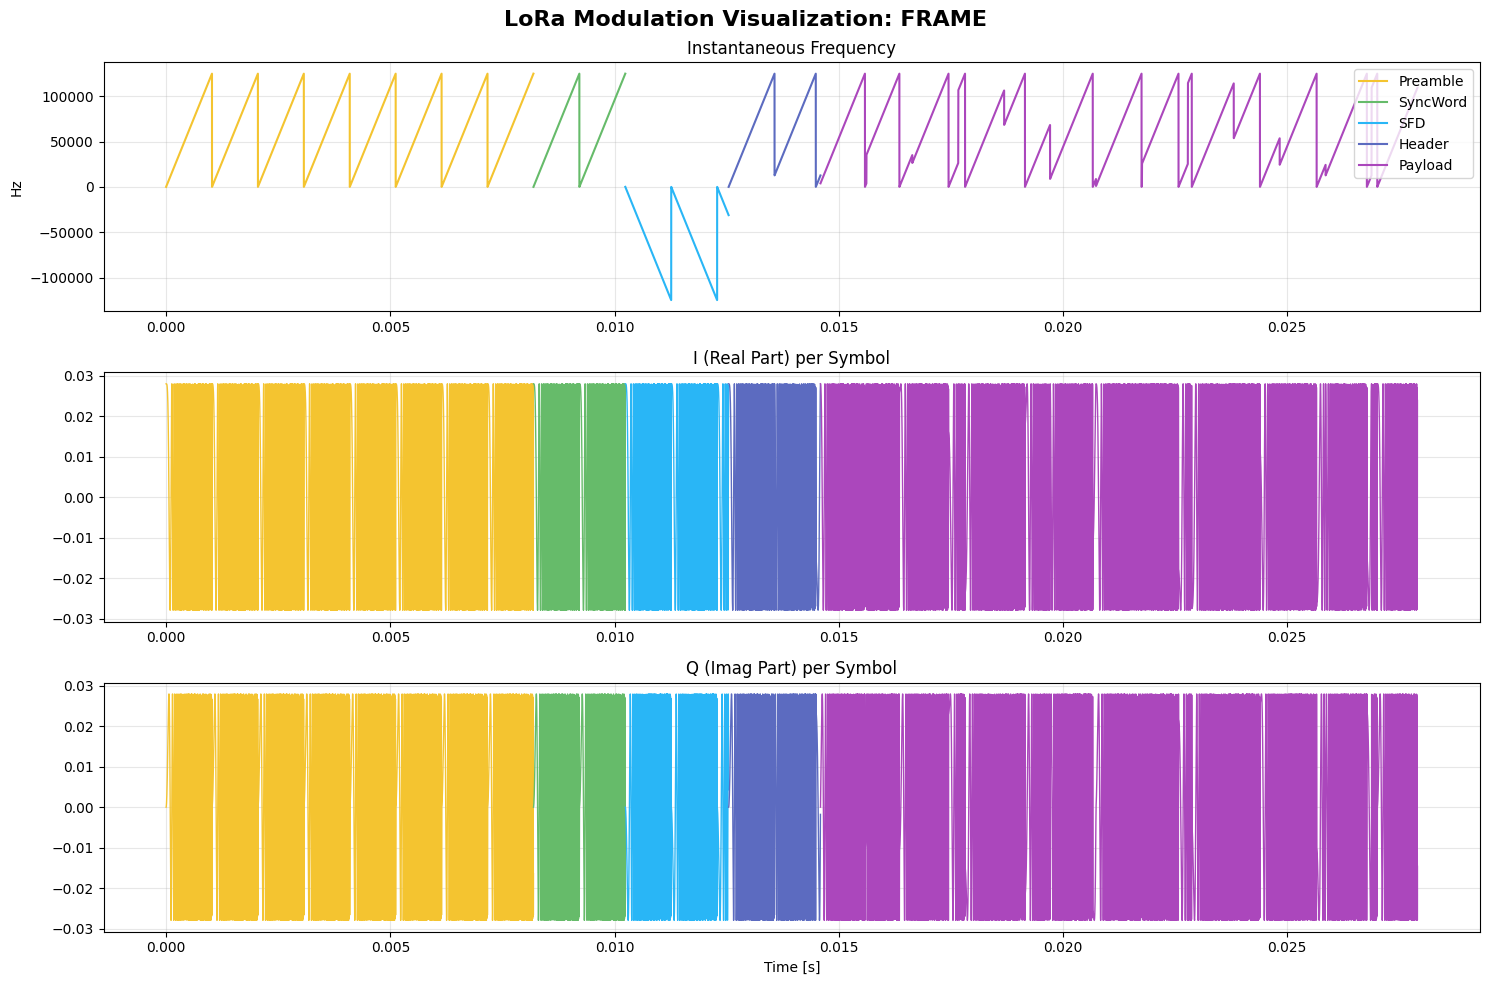

[JupyterNotebook - demo] Expected offsets: Preamble 1273, Sync Word: 11513, SFD: 14073, Header: 16953, Payload: 19513
[DechirpBasedSync - run] Found 10 candidates for synchronization.
[DechirpBasedSync - run] Candidate: RunCandidate(row=3, col=1, len=12, sym=127, run_score=0.85, total_score=0.94)
[DechirpBasedSync - run] Candidate: RunCandidate(row=4, col=1, len=12, sym=127, run_score=0.84, total_score=0.90)
[DechirpBasedSync - run] Candidate: RunCandidate(row=2, col=1, len=12, sym=127, run_score=0.83, total_score=0.89)
[DechirpBasedSync - run] Candidate: RunCandidate(row=5, col=1, len=12, sym=127, run_score=0.80, total_score=0.76)
[DechirpBasedSync - run] Candidate: RunCandidate(row=1, col=1, len=12, sym=127, run_score=0.79, total_score=0.75)
[DechirpBasedSync - run] Candidate: RunCandidate(row=7, col=1, len=10, sym=127, run_score=0.76, total_score=0.70)
[DechirpBasedSync - run] Candidate: RunCandidate(row=9, col=1, len=10, sym=126, run_score=0.75, total_score=0.69)
[DechirpBasedSync 

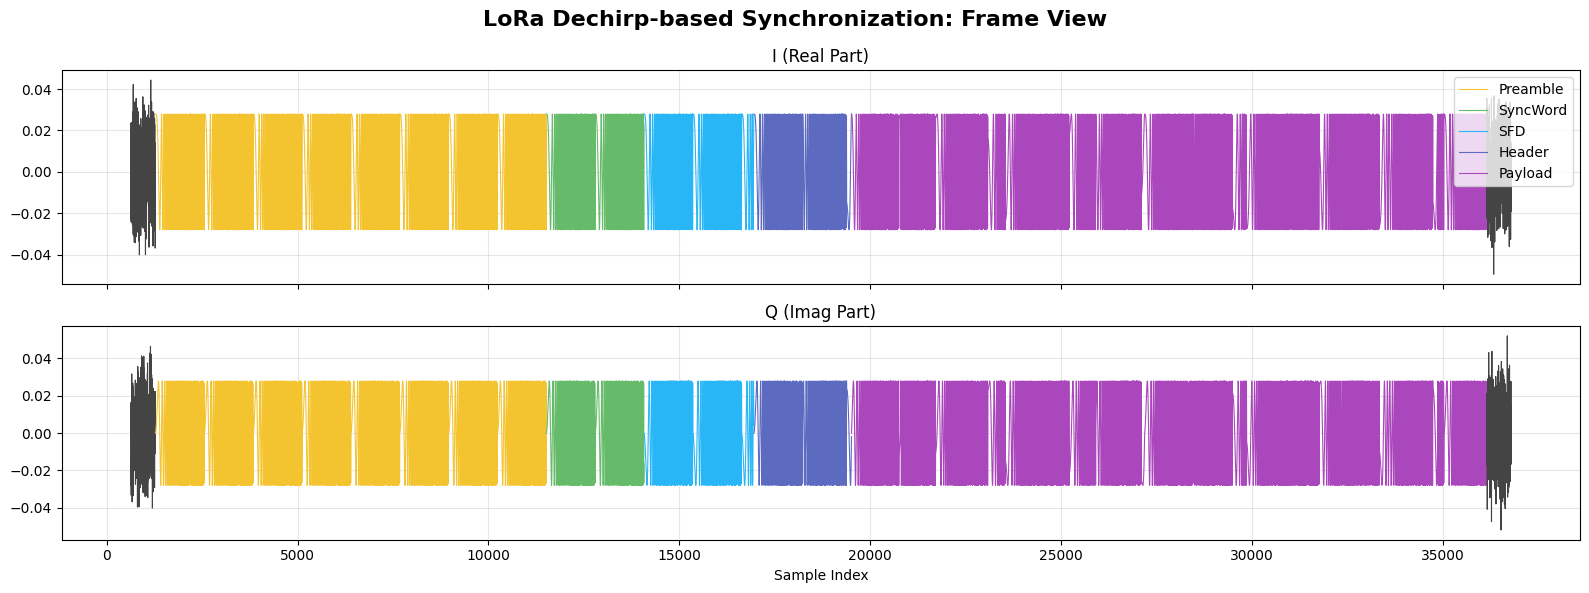

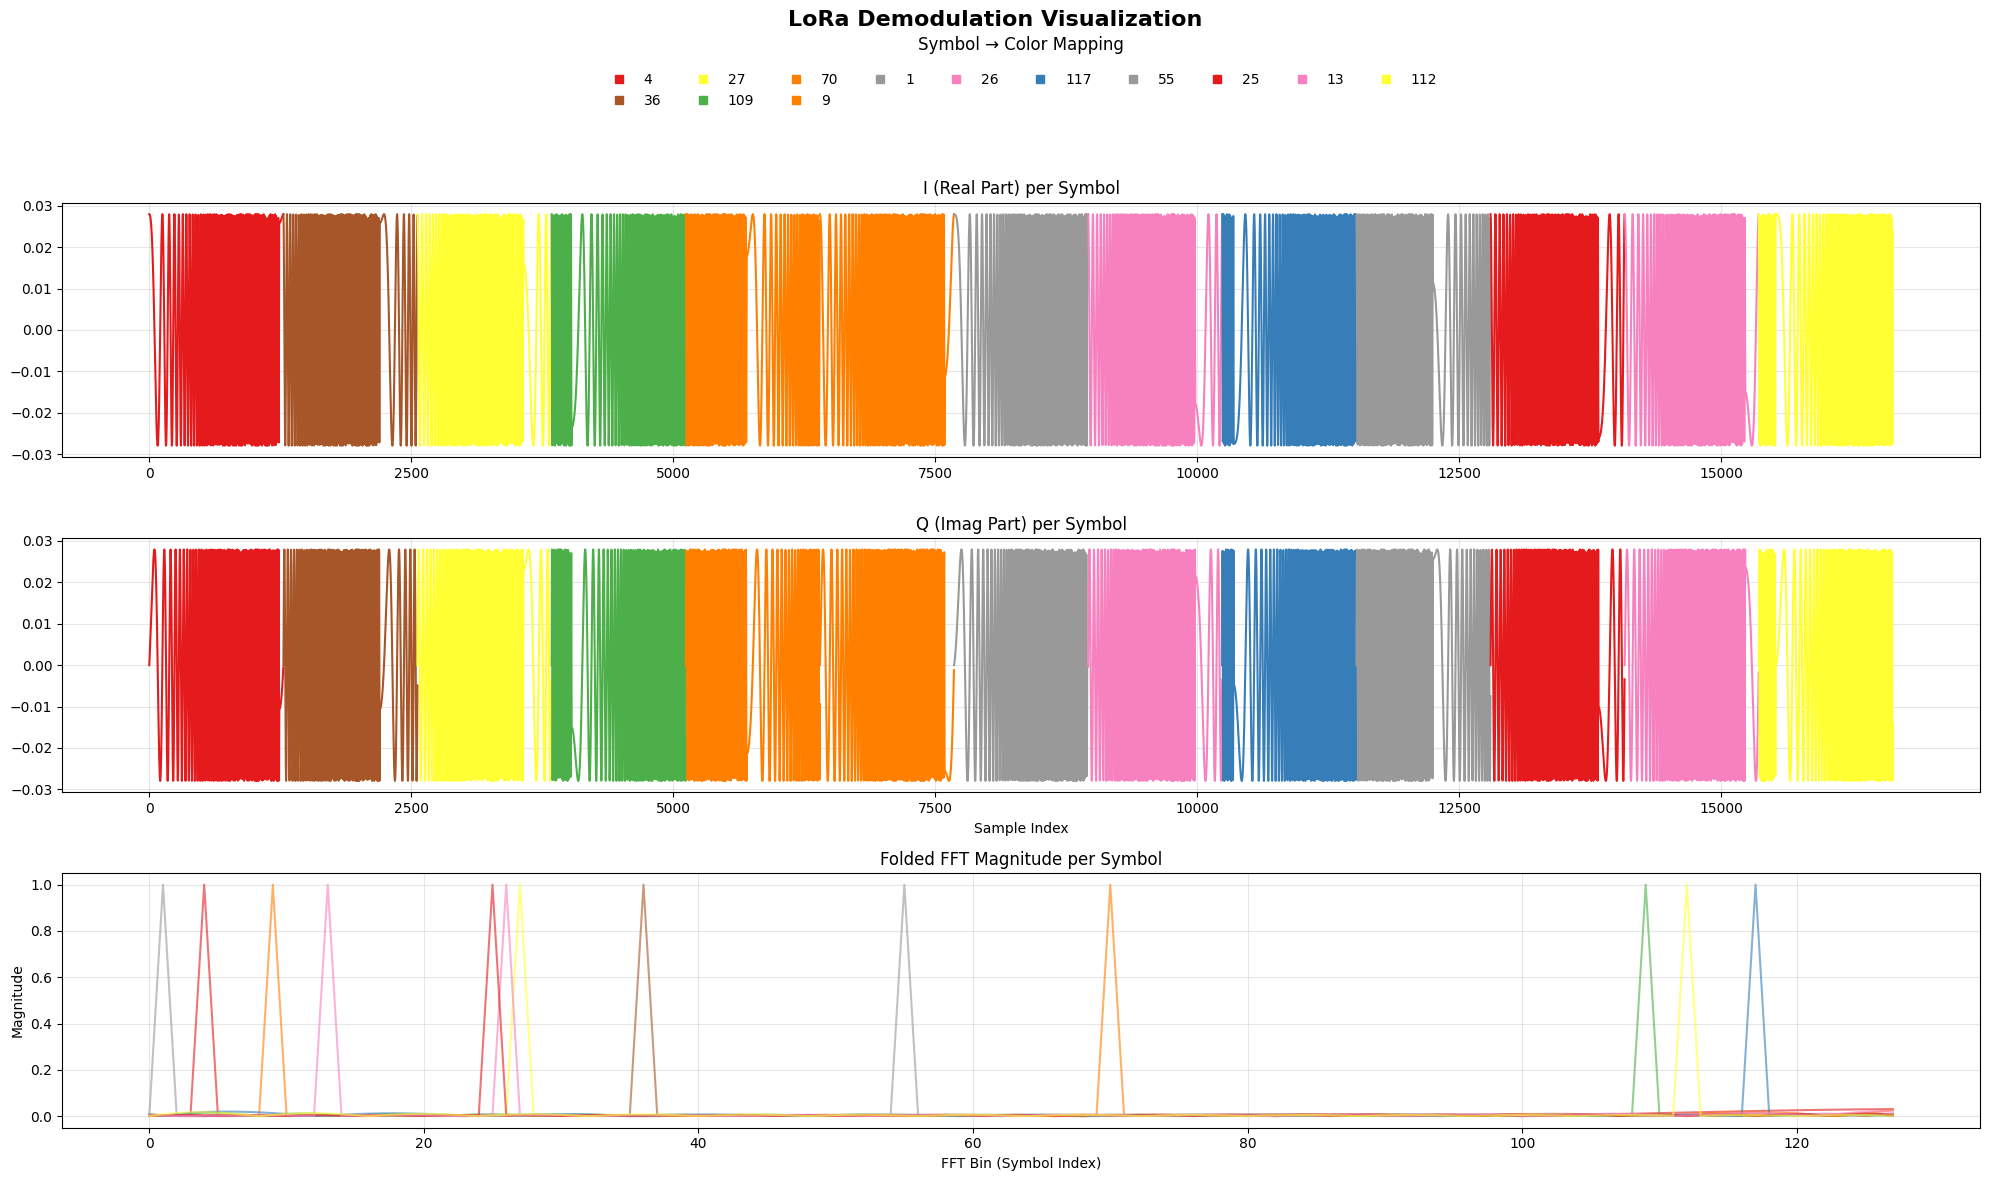


[✓ offset=1273] Payload MATCHES
  ├─ Original: 'Hola Mundo'... (13 symbols)
  └─ Decoded : 'Hola Mundo'... (13 symbols)


[CandidateTrace(index=0, candidate=RunCandidate(row_idx=3, col_idx=1, run_len=12, symbol=127, run_score=0.8486339449882507, total_score=0.9399999666093175), sync_offset=2553, sfd_end_offset=14400, header_syms=(0, 13), decoded_payload_len=13, needed_samples=16640, available_samples=1027840, status='success', error_type=None, error_msg=None, notes=['cfo=0.000000, sfo=0.000000'])]

In [24]:
MESSAGE = "Hola Mundo"
SYNC_OFFSET = 1273     # Offset to simulate unsynchronization

run_demo(MESSAGE, SYNC_OFFSET, codec, modulator, demodulator, synchronizer)
